### 1. Setup

In [ ]:
!pip install --upgrade transformers
!pip install datasets==4.0.0
!pip install fsspec==2025.7.0

In [2]:
import datasets
datasets.__version__

'4.0.0'

### 2. Import Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score,precision_score, recall_score,f1_score


import keras
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense,Dropout,Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

from datasets import load_dataset
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

from collections import Counter
from tqdm import tqdm

### 3. Loading Dataset

In [4]:
dataset =load_dataset('sst2')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

In [5]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 872
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 1821
    })
})


In [6]:
dataset['train'][:3]

{'idx': [0, 1, 2],
 'sentence': ['hide new secretions from the parental units ',
  'contains no wit , only labored gags ',
  'that loves its characters and communicates something rather beautiful about human nature '],
 'label': [0, 0, 1]}

In [7]:
dataset['train'].features

{'idx': Value('int32'),
 'sentence': Value('string'),
 'label': ClassLabel(names=['negative', 'positive'])}

In [10]:
train_texts = dataset["train"]["sentence"]
train_labels = dataset["train"]["label"]

val_texts = dataset["validation"]["sentence"]
val_labels = dataset["validation"]["label"]

In [11]:
labels = dataset['train'].features['label']
labels

ClassLabel(names=['negative', 'positive'])

## 3. Data preprocessing


### 1. Tokanization

In [12]:
tok =Tokenizer(oov_token='<OOV>')

# fit tokenizer on training data
tok.fit_on_texts(train_texts)

# convert sentence into integers
train_sequence =tok.texts_to_sequences(train_texts)
valid_sequence =tok.texts_to_sequences(val_texts)

print(type(tok))

<class 'keras.src.legacy.preprocessing.text.Tokenizer'>


In [13]:
train_sequence[0]

[4569, 88, 11693, 32, 2, 7157, 8692]

In [14]:
word2_index =tok.word_index
len(word2_index)

13823

In [15]:
# vocab size
# The reason for adding one to be able to map the [padding token]
vocab_size =len(word2_index) +1
vocab_size

13824

### 3. Padding

In [16]:
max_train_sequence_length = max(len(seq) for seq in train_sequence)
max_valid_sequence_length = max(len(seq) for seq in valid_sequence)

max_sequence_length = max(max_train_sequence_length, max_valid_sequence_length)
print(f"Maximum sequence length: {max_sequence_length}")

Maximum sequence length: 49


In [17]:
train_padded_sequences = pad_sequences(train_sequence, maxlen=max_sequence_length, padding='post', truncating='post')
valid_padded_sequences = pad_sequences(valid_sequence, maxlen=max_sequence_length, padding='post', truncating='post')

### 4. Modeling

#### 1. LSTM Model

In [23]:
# 3. Build LSTM Model
embedding_dim = 128

model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_sequence_length),
    Bidirectional(LSTM(128, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])


model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [29]:
print("training ----------")

# Convert labels to numpy arrays
train_labels_np = np.array(train_labels)
val_labels_np = np.array(val_labels)

callbacks =[EarlyStopping(monitor='val_loss',patience=3)]

history = model.fit(
    train_padded_sequences , train_labels_np,
    epochs =5,
    batch_size =64,
    validation_data =(valid_padded_sequences ,val_labels_np) ,
    callbacks=callbacks
    )

training ----------
Epoch 1/5
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 385s 366ms/step - accuracy: 0.8777 - loss: 0.3033 - val_accuracy: 0.8119 - val_loss: 0.4225
Epoch 2/5
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 427s 352ms/step - accuracy: 0.9384 - loss: 0.1632 - val_accuracy: 0.8119 - val_loss: 0.4773
Epoch 3/5
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 376s 346ms/step - accuracy: 0.9603 - loss: 0.1096 - val_accuracy: 0.8234 - val_loss: 0.5290
Epoch 4/5
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 372s 353ms/step - accuracy: 0.9688 - loss: 0.0839 - val_accuracy: 0.8326 - val_loss: 0.5784


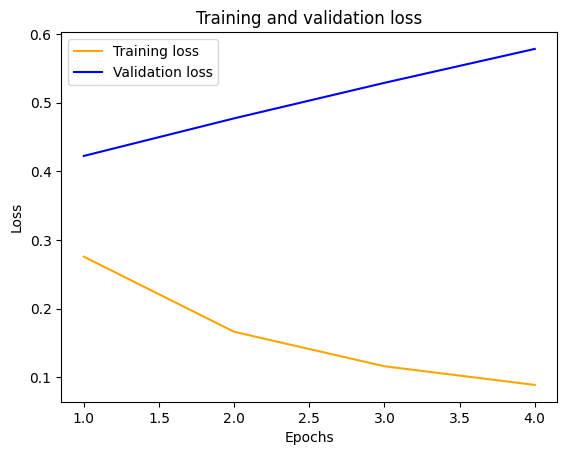

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'orange', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

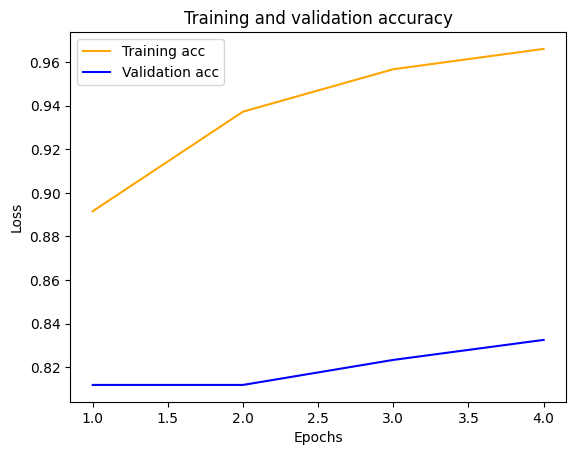

In [31]:
acc_values = history.history['accuracy']
val_acc_values = history.history['val_accuracy']

plt.plot(epochs, acc, 'orange', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Model performance

In [32]:
valid_loss ,valid_acc = model.evaluate(valid_padded_sequences, val_labels_np)
valid_acc

28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.8273 - loss: 0.6129


0.8325688242912292

In [39]:
def make_prediction(test_sequenc_padding):

           test_predictions_prob = model.predict(test_sequenc_padding)

          # Convert probabilities to binary predictions (threshold = 0.5)
           test_predictions_binary = (test_predictions_prob > 0.5).astype(int).flatten()

           predictions = []
           for prediction in test_predictions_binary:
               if prediction == 0:
                   predictions.append('negative')
               elif prediction == 1:
                   predictions.append('positive')
               else:
                   predictions.append('UNKNOWN') # Handle unexpected values

           return predictions

In [40]:
y_valid_pred =make_prediction(valid_padded_sequences)

y_valid =[labels.int2str(label) for label in val_labels]
print(y_valid)
print(classification_report(y_valid,y_valid_pred))

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step
['positive', 'negative', 'positive', 'positive', 'negative', 'positive', 'negative', 'negative', 'positive', 'negative', 'positive', 'negative', 'negative', 'positive', 'negative', 'positive', 'positive', 'positive', 'negative', 'negative', 'negative', 'negative', 'negative', 'positive', 'positive', 'negative', 'negative', 'positive', 'negative', 'negative', 'positive', 'negative', 'positive', 'negative', 'negative', 'negative', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'negative', 'negative', 'negative', 'positive', 'positive', 'negative', 'negative', 'positive', 'positive', 'positive', 'negative', 'positive', 'negative', 'negative', 'negative', 'negative', 'positive', 'negative', 'positive', 'positive', 'negative', 'negative', 'positive', 'positive', 'positive', 'negative', 'negative', 'positive', 'positive', 'positive', 'negative', 'positive', 'negative', 'positive', 'positive', 'negative',

### Test Cases

In [42]:
test_cases = [
    {"text": "I love you", "label": "positive"},
    {"text": "I hate you", "label": "negative"},
    {"text": "I hate the selfishness in you", "label": "negative"},
    {"text": "I hate anyone hurts you", "label": "positive"},
    {"text": "I hate anyone hurting you", "label": "positive"},
    {"text": "I hate anyone hurting you, you are my partner", "label": "positive"},
    {"text": "I hate anyone hurting you, you are my love", "label": "positive"},
    {"text": "I like rude people", "label": "negative"},
    {"text": "I don't like rude people", "label": "positive"},
    {"text": "I hate polite people", "label": "negative"},
    {"text": "I don't hate polite people", "label": "positive"},
]

test_cases_df = pd.DataFrame(test_cases)
test_cases_df

,text,label
0,I love you,positive
1,I hate you,negative
2,I hate the selfishness in you,negative
3,I hate anyone hurts you,positive
4,I hate anyone hurting you,positive
5,"I hate anyone hurting you, you are my partner",positive
6,"I hate anyone hurting you, you are my love",positive
7,I like rude people,negative
8,I don't like rude people,positive
9,I hate polite people,negative


In [45]:
def process_test_sentence(test_sentences):
   # 1. tokenize sentence to sequence
   test_sequence =tok.texts_to_sequences(test_sentences)
   # 2. padding sequence to maximumn length
   test_sequenc_padding =pad_sequences(test_sequence,maxlen =max_sequence_length,padding ='post',truncating='post')

   return test_sequenc_padding

test_sequenc_padding = process_test_sentence(test_cases_df['text'])

In [46]:
y_pred =make_prediction(test_sequenc_padding)
y_true =test_cases_df['label']


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


In [47]:
test_cases_df['LSTM_pred'] =y_pred
test_cases_df.head(10)

,text,label,LSTM_pred
0,I love you,positive,positive
1,I hate you,negative,negative
2,I hate the selfishness in you,negative,negative
3,I hate anyone hurts you,positive,negative
4,I hate anyone hurting you,positive,negative
5,"I hate anyone hurting you, you are my partner",positive,negative
6,"I hate anyone hurting you, you are my love",positive,positive
7,I like rude people,negative,negative
8,I don't like rude people,positive,negative
9,I hate polite people,negative,negative


### Fine Tuning DistilBERT

### 1. Reset Dataset Formate

In [ ]:
dataset.reset_format()

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 872
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 1821
    })
})

In [ ]:
labels = dataset['train'].features['label']
labels

ClassLabel(names=['negative', 'positive'])

In [ ]:
model_Id = "distilbert-base-cased"
distilbert_tokenizer = AutoTokenizer.from_pretrained(model_Id)
distilbert_model = TFAutoModelForSequenceClassification.from_pretrained(model_Id, num_labels=labels.num_classes,from_pt=True)

pytorch_model.bin:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'cla

In [ ]:
from transformers import DataCollatorWithPadding

# Remove return_tensors from preprocessing
def preprocess_function(batch, tokenizer):
    return tokenizer(batch["sentence"], truncation=True)  # No padding here

dataset_encoded = dataset.map(
    preprocess_function,
    batched=True,
    fn_kwargs={"tokenizer": distilbert_tokenizer}
)

# Use data collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=distilbert_tokenizer, return_tensors="tf")

# Choose only the ['input_ids', 'attention_mask']
tokenizer_columns = distilbert_tokenizer.model_input_names


tf_train_dataset = dataset_encoded["train"].to_tf_dataset(
    columns=tokenizer_columns,
    label_cols=["label"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator
)

tf_valid_dataset = dataset_encoded["validation"].to_tf_dataset(
    columns=tokenizer_columns,
    label_cols=["label"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator
)

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

In [ ]:
from tf_keras.optimizers import Adam
optimizer = Adam(learning_rate=1e-5)

distilbert_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"])

In [ ]:
history = distilbert_model.fit(tf_train_dataset, validation_data=tf_valid_dataset, epochs=3)

Epoch 1/3
2105/2105 [==============================] - 374s 165ms/step - loss: 0.2509 - accuracy: 0.8948 - val_loss: 0.2787 - val_accuracy: 0.9002
Epoch 2/3
2105/2105 [==============================] - 318s 151ms/step - loss: 0.1371 - accuracy: 0.9504 - val_loss: 0.3020 - val_accuracy: 0.8933
Epoch 3/3
2105/2105 [==============================] - 318s 151ms/step - loss: 0.0970 - accuracy: 0.9657 - val_loss: 0.3433 - val_accuracy: 0.8956


In [ ]:
val_loss, val_accuracy = distilbert_model.evaluate(tf_valid_dataset)
print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy * 100:.2f}%")

28/28 [==============================] - 2s 63ms/step - loss: 0.3433 - accuracy: 0.8956
Validation Loss: 0.3433 | Validation Accuracy: 89.56%


In [ ]:
predicted_labels = []

from scipy.special import softmax

for row in test_cases_df.values:
    inputs = distilbert_tokenizer(row[0], padding=True, truncation=True)
    logits = distilbert_model.predict(inputs["input_ids"]).logits
    scores = softmax(logits[0])

    label = "Positive" if scores.argmax() else "Negative"


    predicted_labels.append(label)


1/1 [==============================] - 0s 41ms/step


In [ ]:
y_pred = distilbert_model.predict(tf_valid_dataset).logits.argmax(axis=1)
y_true = dataset_encoded["validation"]["label"]

print(classification_report(y_true,y_pred))

28/28 [==============================] - 2s 63ms/step
              precision    recall  f1-score   support

           0       0.90      0.89      0.89       428
           1       0.89      0.90      0.90       444

    accuracy                           0.90       872
   macro avg       0.90      0.90      0.90       872
weighted avg       0.90      0.90      0.90       872



In [ ]:
test_cases_df['bert_pred'] =predicted_labels

In [ ]:
test_cases_df.head(10)

,text,label,bert_pred
0,I love you,Positive,Positive
1,I hate you,Negative,Negative
2,I hate the selfishness in you,Negative,Negative
3,I hate anyone hurts you,Positive,Positive
4,I hate anyone hurting you,Positive,Negative
5,"I hate anyone hurting you, you are my partner",Positive,Positive
6,"I hate anyone hurting you, you are my love",Positive,Positive
7,I like rude people,Negative,Negative
8,I don't like rude people,Positive,Positive
9,I hate polite people,Negative,Negative
